In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
import math

from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1.데이터 로드

In [2]:
train = pd.read_csv("/content/drive/MyDrive/공모전/2020 DECON CUP/train.csv", encoding = 'euc-kr')


train['DateTime'] = pd.to_datetime(train.DateTime)
train['date'] = train.DateTime.dt.date
train  = train.groupby('date').sum().reset_index()

In [3]:
train

,date,사용자,세션,신규방문자,페이지뷰
0,2018-09-09,281,266,73,1826
1,2018-09-10,264,247,51,2092
2,2018-09-11,329,310,58,1998
3,2018-09-12,300,287,45,2595
4,2018-09-13,378,344,50,3845
...,...,...,...,...,...
787,2020-11-04,4516,4472,1196,112683
788,2020-11-05,4155,4037,1044,102901
789,2020-11-06,3663,3576,825,88015
790,2020-11-07,2472,2417,531,57386


In [4]:
train = train.set_index("date")

# 2.EDA & 전처리

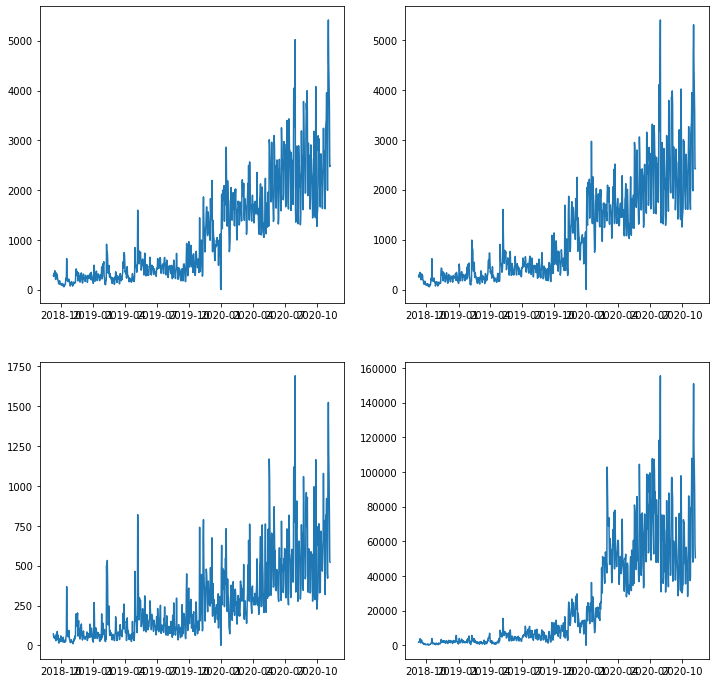

In [5]:
fig, ax = plt.subplots(2,2,figsize=(12,12))

count = 0
for i in range(0,2):

  for j in range(0,2):

    ax[i][j].plot(train.iloc[:,count])
    count+=1

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49464 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49496 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49888 missing from current font.
  font.set_

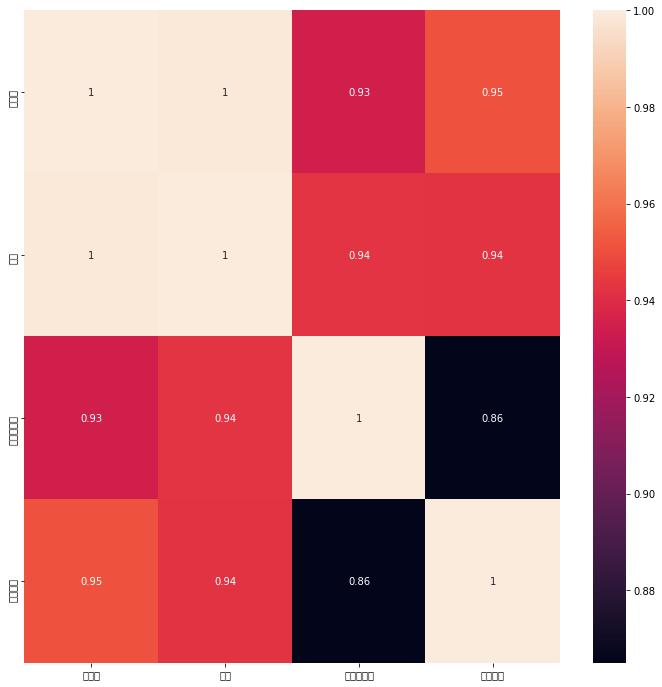

In [6]:
fig = plt.figure(figsize=(12,12))
sns.heatmap(train.corr(),annot=True)

In [7]:
train = np.log(train)

In [8]:
train

,사용자,세션,신규방문자,페이지뷰
date,,,,
2018-09-09,5.638355,5.583496,4.290459,7.509883
2018-09-10,5.575949,5.509388,3.931826,7.645876
2018-09-11,5.796058,5.736572,4.060443,7.599902
2018-09-12,5.703782,5.659482,3.806662,7.861342
2018-09-13,5.934894,5.840642,3.912023,8.254529
...,...,...,...,...
2020-11-04,8.415382,8.405591,7.086738,11.632334
2020-11-05,8.332068,8.303257,6.950815,11.541523
2020-11-06,8.206038,8.182000,6.715383,11.385263


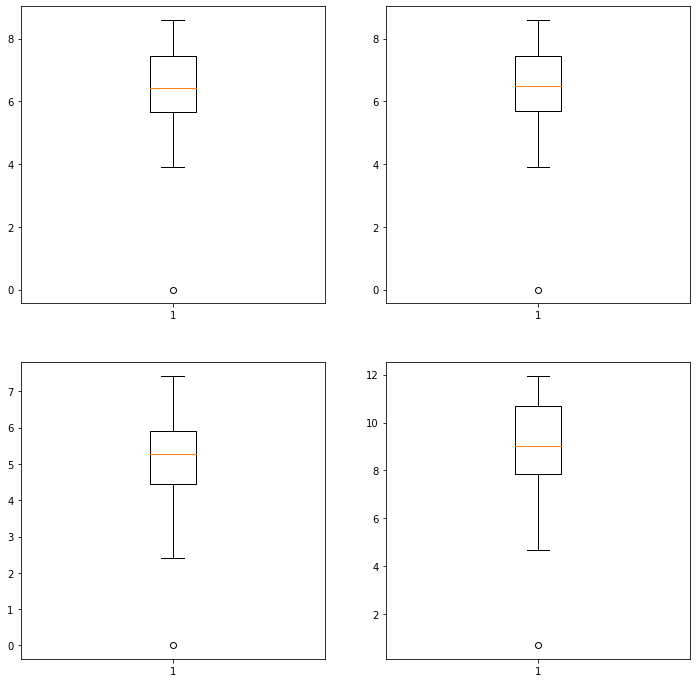

In [9]:
fig, ax = plt.subplots(2,2,figsize=(12,12))

count = 0
for i in range(0,2):

  for j in range(0,2):

    ax[i][j].boxplot(train.iloc[:,count])
    count+=1

In [10]:
train = train[train.사용자 > 4]

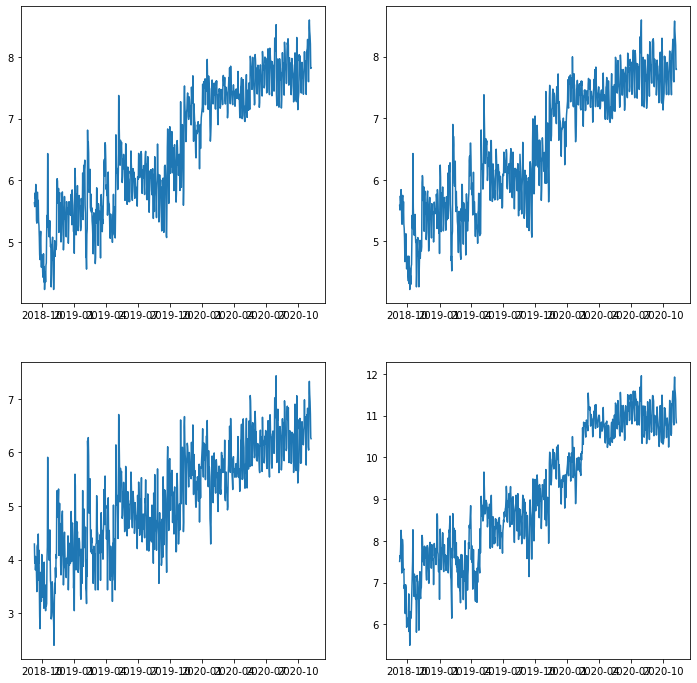

In [11]:
fig, ax = plt.subplots(2,2,figsize=(12,12))

count = 0
for i in range(0,2):

  for j in range(0,2):

    ax[i][j].plot(train.iloc[:,count])
    count+=1

In [12]:
scaler = MinMaxScaler()

index = train.index

train = pd.DataFrame(scaler.fit_transform(train.values),columns=train.columns,index=index)

In [13]:
def make_dataset(data,steps):
    
    X=[]
    y=[]
    
    for i in range(len(data)):
        
        end = i+steps
        
        if end > len(data)-1:
            
            break
            
        seq_x = data[i:end]
        seq_y = data[end]
        
        X.append(seq_x)
        y.append(seq_y)
        
        
    return np.array(X),np.array(y)

In [14]:
X, y = make_dataset(train.values,30)

In [15]:
X.shape, y.shape

((759, 30, 4), (759, 4))

# 3,모델링

In [50]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import EarlyStopping
import tensorflow as tf

from sklearn.metrics import mean_squared_error

In [17]:
X_val,y_val = X[608:,:],y[608:,:]

In [ ]:
strategy = tf.distribute.MirroredStrategy()
early_stopping = EarlyStopping(patience = 20,monitor="val_loss")

In [115]:
# Code for optimization

"""
loss = []
val_loss = []

with strategy.scope():

  for i in range(10,200,10):

    print("-------------------------------- Number of cell : {}".format(i))


    model = Sequential()
    model.add(LSTM(i,activation="tanh",input_shape=(30,4),return_sequences=True))
    model.add(LSTM(i,activation="tanh"))
    model.add(Dense(4))
    adam = optimizers.Adam(lr=0.003)
    model.compile(optimizer=adam,loss="mse")

    hist = model.fit(X,y,epochs=200,verbose=1,callbacks=[early_stopping],validation_data=(X_val,y_val),batch_size=64)

    fitted_loss = np.array(hist.history["loss"]).mean()
    loss.append(fitted_loss)

    fitted_val_loss = np.array(hist.history["val_loss"]).mean()
    val_loss.append(fitted_val_loss)
  """

'\nloss = []\nval_loss = []\n\nwith strategy.scope():\n\n  for i in range(10,200,10):\n\n    print("-------------------------------- Number of cell : {}".format(i))\n\n\n    model = Sequential()\n    model.add(LSTM(i,activation="tanh",input_shape=(30,4),return_sequences=True))\n    model.add(LSTM(i,activation="tanh"))\n    model.add(Dense(4))\n    adam = optimizers.Adam(lr=0.003)\n    model.compile(optimizer=adam,loss="mse")\n\n    hist = model.fit(X,y,epochs=200,verbose=1,callbacks=[early_stopping],validation_data=(X_val,y_val),batch_size=64)\n\n    fitted_loss = np.array(hist.history["loss"]).mean()\n    loss.append(fitted_loss)\n\n    fitted_val_loss = np.array(hist.history["val_loss"]).mean()\n    val_loss.append(fitted_val_loss)\n  '

In [100]:
model2 = Sequential()
model2.add(LSTM(70,activation="tanh",input_shape=(30,4),return_sequences=True))
model2.add(LSTM(70,activation="tanh"))
model2.add(Dense(4))
adam = optimizers.Adam(lr=0.003)
model2.compile(optimizer=adam,loss="mse")


hist = model2.fit(X,y,epochs=200,verbose=1,callbacks=[early_stopping],validation_data=(X_val,y_val),batch_size=64)

Epoch 1/200
12/12 [==============================] - 3s 65ms/step - loss: 0.1552 - val_loss: 0.0216
Epoch 2/200
12/12 [==============================] - 0s 10ms/step - loss: 0.0154 - val_loss: 0.0055
Epoch 3/200
12/12 [==============================] - 0s 10ms/step - loss: 0.0091 - val_loss: 0.0053
Epoch 4/200
12/12 [==============================] - 0s 10ms/step - loss: 0.0080 - val_loss: 0.0050
Epoch 5/200
12/12 [==============================] - 0s 9ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 6/200
12/12 [==============================] - 0s 10ms/step - loss: 0.0077 - val_loss: 0.0052
Epoch 7/200
12/12 [==============================] - 0s 10ms/step - loss: 0.0076 - val_loss: 0.0055
Epoch 8/200
12/12 [==============================] - 0s 9ms/step - loss: 0.0073 - val_loss: 0.0052
Epoch 9/200
12/12 [==============================] - 0s 9ms/step - loss: 0.0076 - val_loss: 0.0060
Epoch 10/200
12/12 [==============================] - 0s 9ms/step - loss: 0.0074 - val_loss: 0.0057
Epo

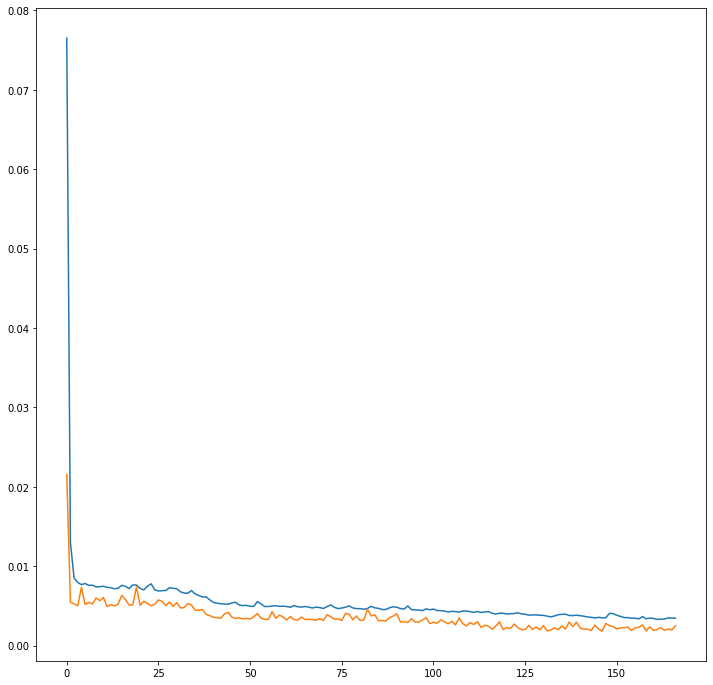

In [103]:
fig = plt.figure(figsize=(12,12))

plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])

In [104]:
np.array(hist.history["loss"]).mean()

0.005471692113819236

# 4.예측

In [105]:
X_30 = train[-30:].values
result = []
for i in range(0,61):

  X_sliced = X_30[i:i+30]
  X_reshape = X_sliced.reshape(-1,30,4)
  yhat = model2.predict(X_reshape)[0]
  X_30 = np.vstack((X_30,yhat))
  result.append(yhat)

In [106]:
pred_result = pd.DataFrame(result,columns=train.columns)

In [107]:
pred_result = pd.DataFrame(scaler.inverse_transform(pred_result),columns=pred_result.columns)

In [108]:
pred_result = pd.DataFrame(np.exp(pred_result.values),columns=pred_result.columns)

In [109]:
pred_result

,사용자,세션,신규방문자,페이지뷰
0,3979.337958,3843.795977,1130.436213,101700.020827
1,4738.896408,4553.613495,1451.507609,122208.894963
2,4461.472190,4232.417596,1300.877576,114875.712360
3,4162.097421,3952.320831,1171.476314,108740.957878
4,3976.126812,3851.982178,1098.078532,105115.075795
...,...,...,...,...
56,2959.310111,2852.134252,778.609812,76809.694774
57,3367.904918,3216.984895,891.809520,86451.452570
58,4865.089486,4645.190702,1437.117913,128180.612661
59,5347.076269,5062.003446,1609.143598,141388.124716


In [110]:
submission = pd.read_csv("/content/drive/MyDrive/공모전/2020 DECON CUP/submission.csv",encoding="euc-kr")

In [111]:
submission = submission.iloc[:,0].to_frame()

In [112]:
fianl_result = submission.join(pred_result)

In [113]:
fianl_result

,DateTime,사용자,세션,신규방문자,페이지뷰
0,2020-11-09,3979.337958,3843.795977,1130.436213,101700.020827
1,2020-11-10,4738.896408,4553.613495,1451.507609,122208.894963
2,2020-11-11,4461.472190,4232.417596,1300.877576,114875.712360
3,2020-11-12,4162.097421,3952.320831,1171.476314,108740.957878
4,2020-11-13,3976.126812,3851.982178,1098.078532,105115.075795
...,...,...,...,...,...
56,2021-01-04,2959.310111,2852.134252,778.609812,76809.694774
57,2021-01-05,3367.904918,3216.984895,891.809520,86451.452570
58,2021-01-06,4865.089486,4645.190702,1437.117913,128180.612661
59,2021-01-07,5347.076269,5062.003446,1609.143598,141388.124716


In [114]:
fianl_result.to_csv("/content/drive/MyDrive/공모전/2020 DECON CUP/final_result.csv",encoding="euc-kr",index=False)